In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
from scipy.interpolate import interp1d;

# some code from Project 1
from utils import * # if in folder from utils.utils import *

# A stochastic SEIR model

We formulate a simple stochastic SEIR model over continuous time and and code this model in Python to be able to run simmulations of epidemic outbreaks. With our simulations we try ty answer questions such as: what is the relationship between the basic reprodution number $R_0$ and the probability of extinction? How is the dynamics in this stochastic SEIR model as compared to that of the deterministic SEIR model? Is there something as a *typical* outcome of the stochastic model?

Our stochastic SEIR model is a continuous time Markov chain and our simmulation utilize what is called Gillespie's algorithm. That is, we have a discrete state space that consits of every combination of postive numbers $S, E, I, R$ such that $S + E + I + R = N$ - where $N$ is the size of the population (which we assume to be fixed). The possible transitions are: an decrease by one of the numbers $S, E, E$ and a simultaneous increas in the succeding number $E, I, R$ - that is one individual goes from being *Infected* to being *Exposed*, or from being *Exposed* to being *Infectious*, etc. The exact transition probabilities will be specified later but as we will see they depend on the current number of Susceptible - Exposed, Infectious and Recoverd - individuals. Gillespie's algorithm simulates the Markov chain by first determining the waiting time until the next transition and then determining which transition takes place.

## Coding the stochastic SEIR model

To make simmulations from the stochastic SEIR model we define the class <code>MarkovChain</code>. An instance of this class holds the parameters of the model in the attribute <code>.parameters</code>, the current state in the attribute <code>.current_state</code> and the current transition probabilities in the attribute <code>.transition_prob</code>. A trajectory of an instance is generated by the mehtod <code>.generate_trajectory()</code> that generates a list of times for transitions, along with a list of the corresponding states the chain was in (the latter is done by repeatedly calling the method <code>.next_state()</code>).

As mentioned above, the algorithm we use to simmulate a trajectory of an outbreak, first determines the waiting time and then which transition takes place at the end of that waiting time. Specifically, given the current state $S, E, I, R$, we calculate the three weights
$$
s\_e := \beta SI \\
e\_i := \rho E \\
i\_r := \gamma I
$$
corresponding to the three possible transitions: one individual goes from being *Susceptible* to being *Exposed*, one individual goes from being *Effedted* to being *Infectious* or one individual goes from being *Infectious* to being *Recovered*. The waiting time is then taken to be the outcome of an Exponential random variable with parameter $W := s\_e + e\_i + i\_r$. The transition is chosen randomly - with probabilities for each transition their corresponding weight divided by the sum of the three weights. This is then repeated until there are no more *Exposed* or *Infectious* indivuduals, in whih case the simulation stops, or unitl we run up to a predetermined stopping time.

In [363]:
class MarkovChain:
    def __init__(self, parameters, initial_state, initial_time=0):
        """
        Initialize the MarkovChain instance.
        
        Parameters
        ----------
        parameters: tuple
            tuple of the parameters: infection rate, transition rate from exposed to
            infectious, and recovery rate
        initial_state: tuple
            initial state of the system (S, E, I, R)
        initial_time: float
            initial time of the outbreak
        scaling_factors: tuple
            scaling factors to make behaviour more similar to deterministic SEIR
            
        Attributes
        ----------
        transition_prob: dict
            A dict object representing the current transition "probabilities" in
            the Markov Chain. Should be of the form {(S-1, E+1, I, R): s_e,
            (S, E-1, I+1, R): e_i, (S, E, I-1, R+1): i_r}
        """
        self.current_time = initial_time
        self.parameters = parameters
        self.current_state = initial_state
        
        
    def generate_trans_prob(self):
        """
        The transition "probabilities" is generated from the current state. The
        transition probabilities are given in form of a 
        dictionary,with tuples of possible transitons as keys and corresponding
        "probabilities" as values. This dictionary is kept in the attribute
        .transition_prob
        """
        S, E, I, R = self.current_state
        beta, rho, gamma = self.parameters
        
        s_e = beta*S*I
        e_i = rho*E 
        i_r = gamma*I 
        
        self.transition_prob = {(S-1, E+1, I, R): s_e,
                (S, E-1, I+1, R): e_i,
                (S, E, I-1, R+1): i_r}
    
    
    def generate_time_step(self):
        '''
        Generates the time of the next event give the current_state and
        transition_probabilities.
        '''
        
        S, E, I, R = self.current_state
        beta, rho, gamma = self.parameters
        
        s_e, e_i, i_r = self.transition_prob.values()
        W = s_e + e_i + i_r
        
        dt = -np.log(np.random.uniform(0.0, 1.0)) / W
        self.current_time += dt
    
    
    def next_state(self):
        """
        Generates the state of the random variable at the next time
        instance.
        
        Parameters
        ----------
        current_state: tuple 
            The current state of the system.
        """
        transition_prob = self.transition_prob
        states =  list(transition_prob.keys())
        probabilities = list(transition_prob.values())
        
        # make probabilities sum to one
        probabilities = [p / sum(probabilities) for p in probabilities]
        
        indx = np.random.choice(len(states), p=probabilities)
        self.current_state = states[indx]
    
    
    def generate_trajectory(self, T=100, initial_state=None):
        """
        Generates a trajectory of the SEIR system up to time T.
        
        Parameters
        ----------
        T: float
            maximum time of the trajectory
        initial_state: tuple
            optional argument to be able to repeatedly generate trajectories
            
        Returns
        -------
        t_vals: list
            a list of the times when the transitions took place
        trajectory: 
        """
        self.current_time = 0
        
        if initial_state != None:
            self.current_state = initial_state
        
        trajectory = [self.current_state]
        t_vals = [0]
        
        while self.current_time < T:
            # break if no effected or infectious
            if self.current_state[1] + self.current_state[2] == 0:
                break
            
            self.generate_trans_prob()
            self.generate_time_step()
            self.next_state()
            
            # append values to output
            trajectory.append(self.current_state)
            t_vals.append(self.current_time)
            
        return t_vals, trajectory

A simulated outbreak from our model may look as follows.

In [435]:
# initalize an epidemic
epidemic = MarkovChain(parameters=(0.8, 7, 8),
                       initial_state=(99, 0, 3, 0))

# generate a trajectory and corresponding transition times 
t_val, traj = epidemic.generate_trajectory(T=50);

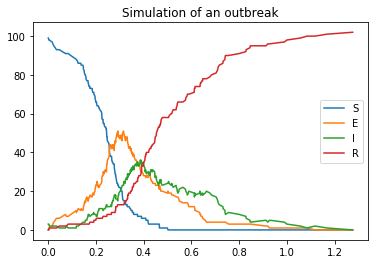

In [436]:
plt.plot(t_val, traj)
plt.title('Simulation of an outbreak')
plt.legend(['S', 'E', 'I', 'R'])
plt.show()

## Basic reproduction number and the probability of extinction
In contrast to a deterministic SEIR model, a path from a stochastic model may go completely extinct - meaning that from some point onward there are no *Exposed* or *Infectious* individuals and from which point the process won't develope. In the case of an epidemic, if the basic reproduction number
$$
R_0 := \frac{\beta S(0)}{\gamma},
$$
is below one, an infectious individual - in the early part of the outbreak - on awarege infects less than on individual. The epidemic would thus go extinct and not spread through the whole population. It would be interesting to see if this holds true in our model. 
We define an epidemic to have gone extinct as, that at most $10\%$ of initially suceptible population got infected. To calculate the probability of extinction, for different basic reproduction numbers, we simmulate 100 trajectories for each basic reporduction number and estimate the probability of extinction as the proportion of trajectories which lead to extinction.

Below we estimate the probability of extinction, with $3$ initually infectious individuals in a population of $100$ individuals, for $R_0$ in the range from $0.1$ to $4$. Extinction is defined as that less than $10 \%$ of the initial suceptible population of got infected.

In [199]:
gamma = 10
beta_values = np.linspace(0.01, 0.4, 10)
p = pd.DataFrame(index=beta_values)
I0 = 3

S0 = 100 - I0

probabilities = []
for beta in beta_values:
    # initalize epidemic with beta parameter
    epidemic = MarkovChain(parameters=(beta, 5, gamma),
                       initial_state=(0, 0, 0, 0))

    no_extinction = 0
    for _ in range(100):

        _, traj = epidemic.generate_trajectory(T=50, initial_state=(S0, 0, I0, 0))

        # if final number of recovered >= 0.10 initially suceptible - no extinction!
        if traj[-1][3] >= 0.1*traj[0][0]:
            no_extinction +=1

    prob = (100 - no_extinction)/100
    probabilities.append(prob)

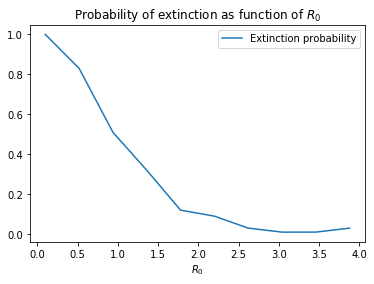

In [200]:
# R0 = S0 * beta / gamma
R_0_vals = S0*beta_values / gamma

plt.plot(R_0_vals, probabilities, label='Extinction probability')
plt.title(r'Probability of extinction as function of $R_0$')
plt.xlabel('$R_0$')
plt.legend()
plt.show()


We observe that the probability of extinction decreases fast with $R_0$ and is about $50 \%$ for $R_0$ equal to one. When $R_0$ is close to two, the probability of extinction is fairly close to zero. 

## Extinction probability as a function of intitial number of infected
The extinction probability does of course depend on the initial number of infected individuals. Below is a a plot of the exctinction probability as a function of $\beta$ for different number of initially infected individuals. (As $R_0$ depnds on the number of initially infected individuals, we cannot plot the different curves with $R_0$ on the $x$-axis. But the $R_0$-values for the curves goes from about $0.1$ to $4$ as above.) The probability of extinction \[here defined as that at most $25 \%$ of the initially susceptible got infected \] decreses faster with more initially infected. With only one individual initally infected, the probability of extinction does not go below $10 \%$ - evan as $R_0$ grows to $4$.

In [301]:
gamma = 10
beta_values = np.linspace(0.05, 0.97, 10)
p = pd.DataFrame(index=beta_values)

for I0 in range(1,5):
    S0 = 100 - I0

    probabilities = []
    for beta in beta_values:
        # initalize epidemic with beta parameter
        epidemic = MarkovChain(parameters=(beta, 5, gamma),
                           initial_state=(0, 0, 0, 0))

        no_extinction = 0
        for _ in range(100):

            _, traj = epidemic.generate_trajectory(T=50, initial_state=(S0, 0, I0, 0))

            # if final number of recovered >= 0.25 initially suceptible - no extinction!
            if traj[-1][3] >= 0.25*traj[0][0]:
                no_extinction +=1

        prob = (100 - no_extinction)/100
        probabilities.append(prob)
    
    p['Number of initially susceptible: '+str(I0)] = np.array(probabilities)

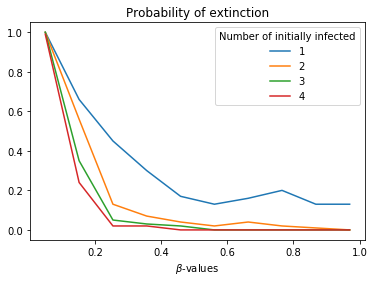

In [302]:
ax = p.plot(title='Probability of extinction')
ax.set_xlabel(r'$\beta$-values')
ax.legend(['1','2','3', '4'], title='Number of initially infected')
plt.show()


## Comparison of dynamics in determnistic versus stochastic models

As the behaviour in our stochastic SEIR model changes from path to path, to compare the dynamics to that of a deterministic model, we would rather compare the avarage dynamic of multiple trajectories in our stochastic model to the dynamic of the deterministic SEIR model. To do so, we have to overcome the problem that events occur at different time points in every trajectory (and also possibly that a trajectory that leads to extinction is shorter).

One possible way to overcome the problem that events occur at different points in time is to interpolate each generated trajectory and then extract points, evenly spaced in time from each such interpolation. Thus we use <code>interp1d</code> from SciPy.interpolate to interpolate each trajectory generated by our stochastic model. From each interpolation we then extract the values of the curves at the same points in time. We are thus are able to take the avareage value of each point in time.

From the first project we have the function <code>solve_seir</code> that gives a numeric solution to the deterministic SEIR model. Trying to compare the dynamics with the same parameters we get a significant difference. Instead we scale the parameters $\beta, \rho$ and $\gamma$ with $170, 5$ and $1.1$ respectively. Then with the input $\beta=0.008, \rho=5, \gamma=10$ and $(S_0, E_0, I_0, R_0)=(97,0,3,0)$ we get the following output.

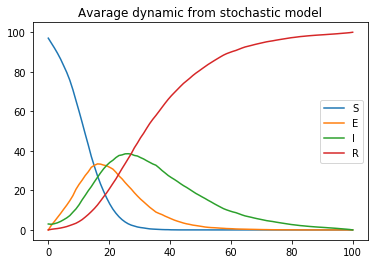

In [391]:
result = np.zeros(shape=(100, 4))

epidemic = MarkovChain(parameters=(0.008*170, 5*4, 10*1.1),
                       initial_state=(97, 0, 3, 0)
                       )

for i in range(100):

    t, traj = epidemic.generate_trajectory(T=50, initial_state=(97, 0, 3, 0))
    
    # for easier slicing we convert traj to a numpy array
    traj = np.array(traj)
    # interpolate each curve
    fs = interp1d(t, traj[:, 0])
    fe = interp1d(t, traj[:, 1])
    fi = interp1d(t, traj[:, 2])
    fr = interp1d(t, traj[:, 3])
    
    # extract evenly space points from interpolation
    S = fs(np.linspace(0, t[-1], 100))
    E = fe(np.linspace(0, t[-1], 100))
    I = fi(np.linspace(0, t[-1], 100))
    R = fr(np.linspace(0, t[-1], 100))

    result = result + np.column_stack((S,E,I,R))

# get mean at each point
result = result / 100

plt.plot(np.linspace(0,100, 100), result)
plt.title('Avarage dynamic from stochastic model')
plt.legend(['S', 'E', 'I', 'R'])
plt.show()

In [431]:
# to have a look at our solver of the determenistic SEIR system
# help(solve_seir)

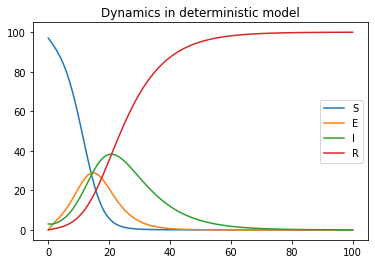

In [433]:
seir = solve_seir(T=99, n=200, S0=97, I0=3, beta=0.008, rho=5, gamma=10)
plt.plot(np.linspace(0, 100, 100), seir)
plt.title('Dynamics in deterministic model')
plt.legend(['S', 'E', 'I', 'R'])
plt.show()

 Which, according to a visual gauge, are quiet similar. 

### Including or excluding path that lead to extinction
On might wonder if trajectories that lead to extinction greatly skew the result of avaraging multiple trajetories. To investigate this we compare the result of including or excluding the paths that lead to extinction.

Number of excluded paths (of 100):  28


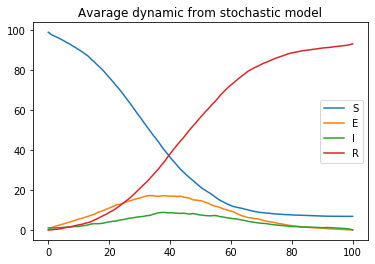

In [385]:
result = np.zeros(shape=(100, 4))

epidemic = MarkovChain(parameters=(0.3, 5, 10),
                       initial_state=(99, 0, 1, 0)
                       )
count = 0
for i in range(100):

    t, traj = epidemic.generate_trajectory(T=50, initial_state=(99, 0, 1, 0))
    
    if traj[-1][3] < 0.15*traj[0][0]:
        continue
    
    # for easier slicing we convert traj to a numpy array
    traj = np.array(traj)
    # interpolate each curve
    fs = interp1d(t, traj[:, 0])
    fe = interp1d(t, traj[:, 1])
    fi = interp1d(t, traj[:, 2])
    fr = interp1d(t, traj[:, 3])
    
    # extract evenly space points from interpolation
    S = fs(np.linspace(0, t[-1], 100))
    E = fe(np.linspace(0, t[-1], 100))
    I = fi(np.linspace(0, t[-1], 100))
    R = fr(np.linspace(0, t[-1], 100))
    
    result = result + np.column_stack((S,E,I,R))
    count += 1
# get mean at each point
result = result / count

print('Number of excluded paths (of 100): ', str(100-count))
plt.plot(np.linspace(0,100, 100), result)
plt.title('Avarage dynamic when excluding paths')
plt.legend(['S', 'E', 'I', 'R'])
plt.show()

No excluded paths


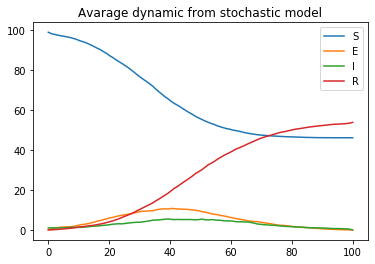

In [387]:
result = np.zeros(shape=(100, 4))

epidemic = MarkovChain(parameters=(0.3, 5, 10),
                       initial_state=(99, 0, 1, 0)
                       )
count = 0
for i in range(100):

    t, traj = epidemic.generate_trajectory(T=50, initial_state=(99, 0, 1, 0))
    
    
    # for easier slicing we convert traj to a numpy array
    traj = np.array(traj)
    # interpolate each curve
    fs = interp1d(t, traj[:, 0])
    fe = interp1d(t, traj[:, 1])
    fi = interp1d(t, traj[:, 2])
    fr = interp1d(t, traj[:, 3])
    
    # extract evenly space points from interpolation
    S = fs(np.linspace(0, t[-1], 100))
    E = fe(np.linspace(0, t[-1], 100))
    I = fi(np.linspace(0, t[-1], 100))
    R = fr(np.linspace(0, t[-1], 100))
    
    result = result + np.column_stack((S,E,I,R))
    count += 1
# get mean at each point
result = result / count

plt.plot(np.linspace(0,100, 100), result)
plt.title('Avarage dynamic when including all paths')
plt.legend(['S', 'E', 'I', 'R'])
plt.show()

Which is the case, as in the latter plot the cuves for the *Susceptible* and *Recoverd* compartment differs greatly. But this should not have effected the previous comparison between the stoachastic and the deterministic model as the $R_0$-value for the input in the stochastic model was about equal to $12$. It is very unlikely that any of the paths included in the mean did go extinct.

## Is there something as a *typical* outbreak?
Is there such a thing as a "typical" oubreak from given parameters in our model? (So that it is reasonable to predict a "typical" outcome.) Or does the final fraction of people vary wildly - given the same input? To test this we will run $10000$ simulations and plot a histogram of the final fraction of recovered individuals.

In [422]:
result = []
epidemic = MarkovChain(parameters=(0.3, 5, 10),
                       initial_state=(98, 0, 1, 0))
                       
for i in range(10000):

    _, traj = epidemic.generate_trajectory(T=50, initial_state=(98, 0, 2, 0))
    
    result.append(traj[-1][3])


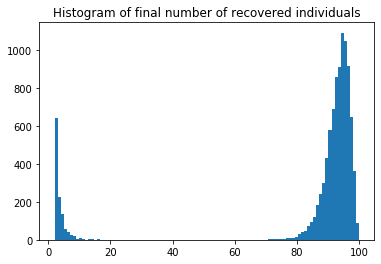

In [423]:
plt.hist(result, bins=100)
plt.title('Histogram of final number of recovered individuals')
plt.show()

In [439]:
# concentration of values 
#concentraton = [i for i in result if i<=3 or 83 < i]
#len(concentraton)

We observe that the distribution is bimodal - corresponding to that an epidemic either may go extinct early or spread through almost the whole population. In fact about $95 \%$ of the oucomes are concentrated to $20 \%$ of the possible outcomes. The bimodality of the distribution also means that the mean isn't very representative. (The mean above is about equal to $82$.) It thus seams reasonable to talk about *two typical outcomes* - as either an early extinction or the epidemic spreading through the population - althogh not of *a typical outcome*.